# **Movie Recommendation System**

![Alt text](image.png)

# Business Understanding
The movie industry is characterized by diverse films and content. For instance, there are many genres, including action, drama, comedy, science fiction, horror among others. Each genre appeals to different tastes and moods, making it hard to pick just one. For a user, this abundance can be both a blessing and a challenge. The sheer volume of movies available can be overwhelming, making it difficult to decide which movie to watch and, more importantly, how to ensure that the chosen movie will be truly enjoyable. In this regard, there is a need for businesses to understand and meet user preferences. 

### Problem Statement
The performance of a streaming platform, especially in terms of user retention and satisfaction, is closely tied to the effectiveness of its recommendation system. This is attributed to the fact that platforms offer an extensive catalog of movies from various genres, time periods, and cultures hence selecting can feel like navigating an intricate maze. Also, movie preferences are highly subjective. What one person finds enjoyable, another might not. It's challenging to predict which movies will resonate with an individual. In this regard, curated collections and suggestions help users discover and ultimately watch movies which align with their preferences.
This project addresses this challenge by developing a recommendation system which analyzes a user's past viewing habits, ratings, and the behavior of similar users to suggest movies tailored to individual tastes. 


### Objective
To develop a model that offers top 5 recommendations to a user based on their ratings of other movies

# Source of Data

The data used was sourced from [MovieLens](https://grouplens.org/datasets/movielens/latest/). I used the small dataset due to limited computational power. I selected two files in line with project objective. 

* Movies File: Contains information about the movies.<br>
`movieId` - Unique identifier for each movie.<br>
`title` - The movie titles.<br>
`genre` - The various genres a movie falls into.<br>

* Ratings file: Contains the ratings for the movies by different users.<br>
`userId` - Unique identifier for each user<br>
`movieId` - Unique identifier for each movie.<br>
`rating` - A value between 0 to 5 that a user rates a movie on. A higher rating indicates a higher preference.<br>
`timestamp` - This are the seconds that have passed since Midnight January 1, 1970(UTC)

## Importing Libraries

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans
from surprise import SVD
from wordcloud import WordCloud


### Reading Data 

In [2]:
# links = pd.read_csv("links.csv")
movies= pd.read_csv("movies.csv")
ratings= pd.read_csv("ratings.csv")
# tags= pd.read_csv("tags.csv")

#### Preview Datasets

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


* The two datasets all have column `movieId` which is a unique identfier. The column was used to join the datasets 
 using innerjoin

In [5]:
ratings.shape

(100836, 4)

* The ratings dataset has 100836 rows and 4 columns

In [6]:
movies.shape

(9742, 3)

* The movies dataset has 9742 rows and 3 rows 

In [7]:
data = pd.merge(ratings, movies, on='movieId', how='inner')

In [8]:
data.shape

(100836, 6)

* The combined dataset has 100836 rows which shows that no data had been lost. 

### Data Understanding

In [9]:
data['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

* The ratings range from0.5 to a maximum of 5.0. 
* The average rating is 3.5 and most ratings fall between 3.0 and 4.0, indicating that users generally rate items positively.
* The standard deviation of 1.04 shows there is moderate variation in the ratings


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


## Data Cleaning
* This section entails checking  for data consisteny, missing values and outliers 

#### Check for missing values 

In [11]:
data.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

#### Checking for Duplicates

In [12]:
# Checking for duplicates
duplicate_rows = data[data.duplicated()]

# Print the duplicate rows
print(duplicate_rows)

Empty DataFrame
Columns: [userId, movieId, rating, timestamp, title, genres]
Index: []


* The data does not have  any duplicated rows

#### Checking for outliers

In [13]:
# Calculate the Z-scores for the 'rating' column
z_scores = stats.zscore(data['rating'])

# Define a threshold for identifying outliers (e.g., Z-score > 3 or < -3)
threshold = 3

# Identify outliers using the threshold
outliers = data[abs(z_scores) > threshold]

# Print the outliers
print("Outliers:")
print(outliers)

Outliers:
Empty DataFrame
Columns: [userId, movieId, rating, timestamp, title, genres]
Index: []


* The column `rating` does not have outliers. The data values are within expected rating range.

##### Data Consistency

In [14]:
# Function to check data consistency and detect placeholders
for column in data.columns:
    unique_values = data[column].unique()
    placeholders = [value for value in unique_values if str(value).strip().lower() in ['placeholder', 'na', 'n/a', 'none']]
    placeholder_count = len(placeholders)    
    unique_value_counts = data[column].value_counts()    
    print(f"Column: '{column}'")
    print(f"Unique value counts:")
    print(unique_value_counts)
    print()
    print(f"Placeholders:")
    print(placeholders)
    print(f"Count of placeholders: {placeholder_count}\n")

Column: 'userId'
Unique value counts:
userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
431      20
194      20
257      20
207      20
189      20
Name: count, Length: 610, dtype: int64

Placeholders:
[]
Count of placeholders: 0

Column: 'movieId'
Unique value counts:
movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: count, Length: 9724, dtype: int64

Placeholders:
[]
Count of placeholders: 0

Column: 'rating'
Unique value counts:
rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

Placeholders:
[]
Count of placeholders: 0



Column: 'timestamp'
Unique value counts:
timestamp
1459787998    128
1459787997    124
1459787996     85
828124616      37
1459787995     37
             ... 
1105649592      1
1270606502      1
1451080652      1
1112288582      1
1493850155      1
Name: count, Length: 85043, dtype: int64

Placeholders:
[]
Count of placeholders: 0

Column: 'title'
Unique value counts:
title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Sex, Drugs & Taxation (2013)          1
Extraordinary Tales (2015)            1
Tomorrow (2015)                       1
Embrace of the Serpent (2016)         1
31 (2016)                             1
Name: count, Length: 9719, dtype: int64

Placeholders:
[]
Count of placeholders: 0

Column: 'genres'
Unique value counts:
genres
Comedy                                                

* The data does  not  have placeholders

## Exploratory Data Analysis

### Distribution of Ratings

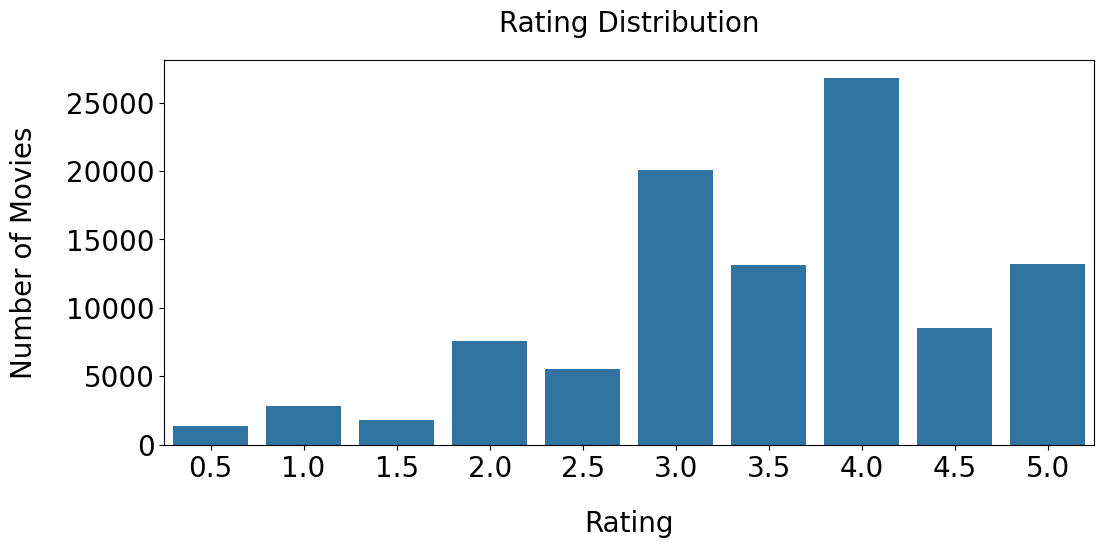

In [15]:
# Bar graph for distrbution of ratings
fig, ax = plt.subplots(figsize=(12, 5))
rating_counts = data['rating'].value_counts().sort_index(ascending= True)

sns.barplot(x=rating_counts.index,
            y=rating_counts.values,
            color='tab:blue')

plt.title("Rating Distribution", fontsize=20, pad=20)
plt.xlabel("Rating", fontsize=20, labelpad=20)
plt.ylabel("Number of Movies", fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)

plt.show()

#### Top 10 genres 

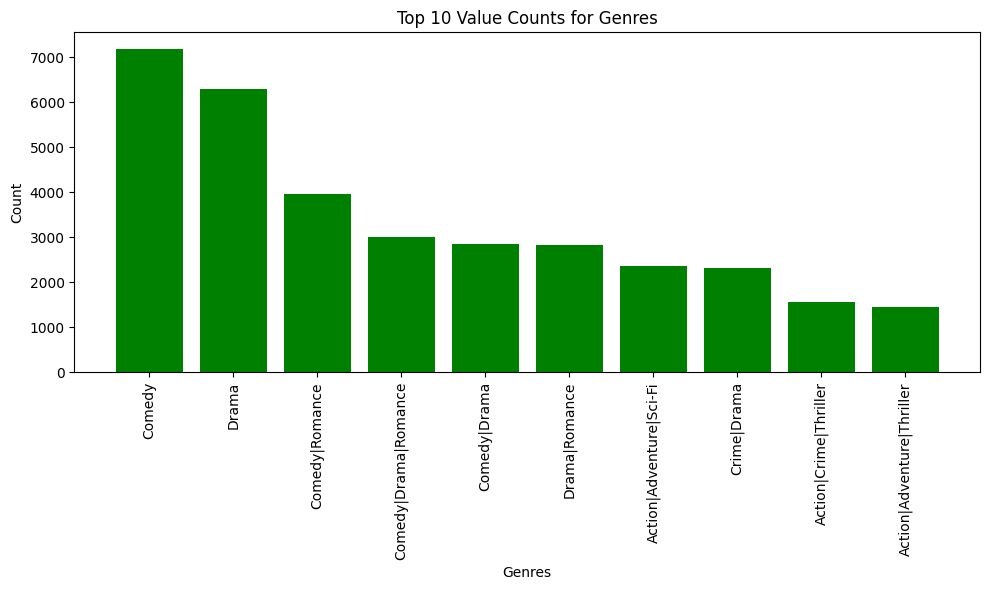

In [16]:
# Top 10 genres 
genres_counts = data['genres'].value_counts().head(10)

# Plotting the value counts
plt.figure(figsize=(10, 6))
plt.bar(genres_counts.index, genres_counts.values, color='green')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Top 10 Value Counts for Genres')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

*Comedy, Drama and Comedy/Romance are the top three performing movie genres while Action|Crime|Thriller, Action|Adventure|Crime|Thriller and Crime|Drama were the least

#### WordCloud for Movie Genres

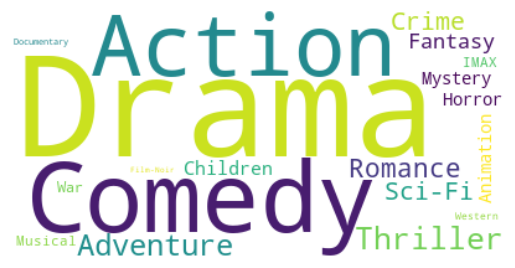

In [17]:
# Extract the genres column
genres_text = '|'.join(data['genres'])
genres_list = genres_text.split('|')

# Create the word frequency dictionary
word_frequency = {}
for genre in genres_list:
    word_frequency[genre] = word_frequency.get(genre, 0) + 1

# Create the WordCloud object
wordcloud = WordCloud(background_color='white')

# Generate the word cloud from the word frequency
wordcloud.generate_from_frequencies(word_frequency)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* `Drama`, `Thriller`, `Action` and `Comedy` are the most popular genres. 
* `Film, Noir` and `Documentary` are the least watched genres.

##### Distribution of movies  by `year released`
* The year released is an important and informative detail about movies

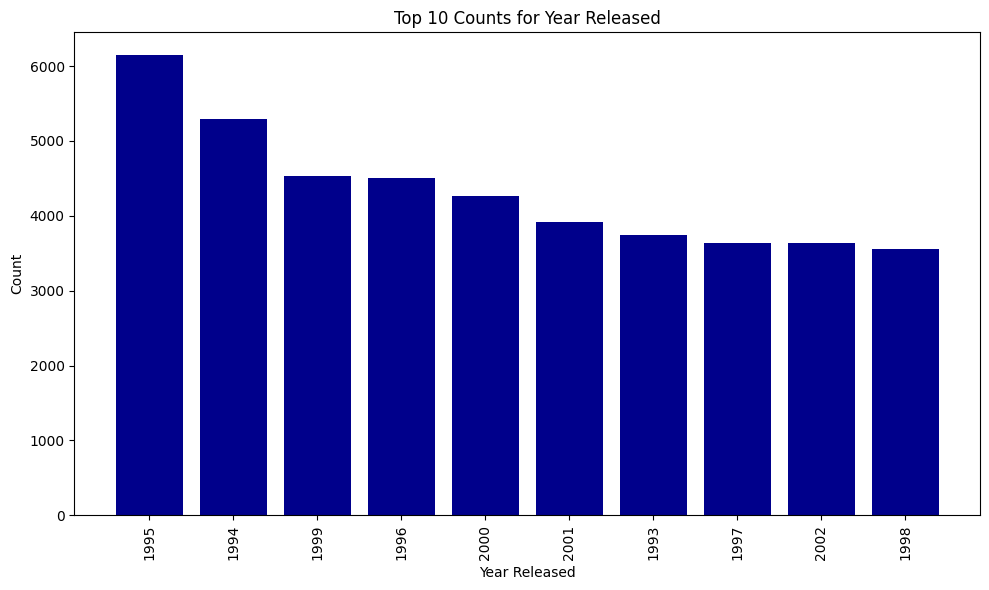

In [18]:
# Extract the year and create a new "year released" column
data['year released'] = data['title'].str.extract(r'\((\d{4})\)')

year_released_counts = data['year released'].value_counts().head(10)

# Sort the value counts by index (year) in descending order
year_released_counts = year_released_counts

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(year_released_counts.index.astype(str), year_released_counts.values, color='darkblue')
plt.xlabel('Year Released')
plt.ylabel('Count')
plt.title('Top 10 Counts for Year Released')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Distribution of movie release by decade
* `Decade` was computed from `year released`

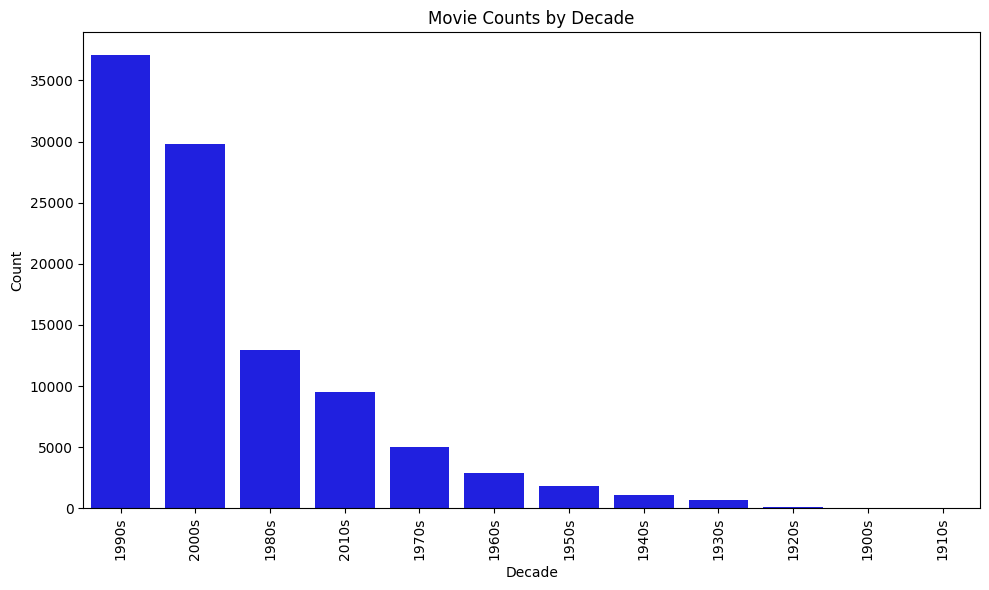

In [19]:
# Drop rows with missing 'year released' values
data.dropna(subset=['year released'], inplace=True)

# Convert the 'year released' column to integers
data['year released'] = data['year released'].astype(int)

# Function to compute decades from year released
def year_to_decade(year):
    return str(year // 10 * 10) + 's'

# Apply the function to create the 'decade' column
data['decade'] = data['year released'].apply(year_to_decade)
decade_counts = data['decade'].value_counts()

# Sort the value counts in descending order
decade_counts = decade_counts.sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_counts.index, y=decade_counts.values, color='blue')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Movie Counts by Decade')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

* Most movies were released in the 1990s followed by 2000s while the least were released in 1910s.There was a steady increase of movie production from 1920s which peaked in the 1990s before declining in the new millenium.

### Distribution of ratings by genre
* Distrbution of ratings by top five and bottom five rated movies

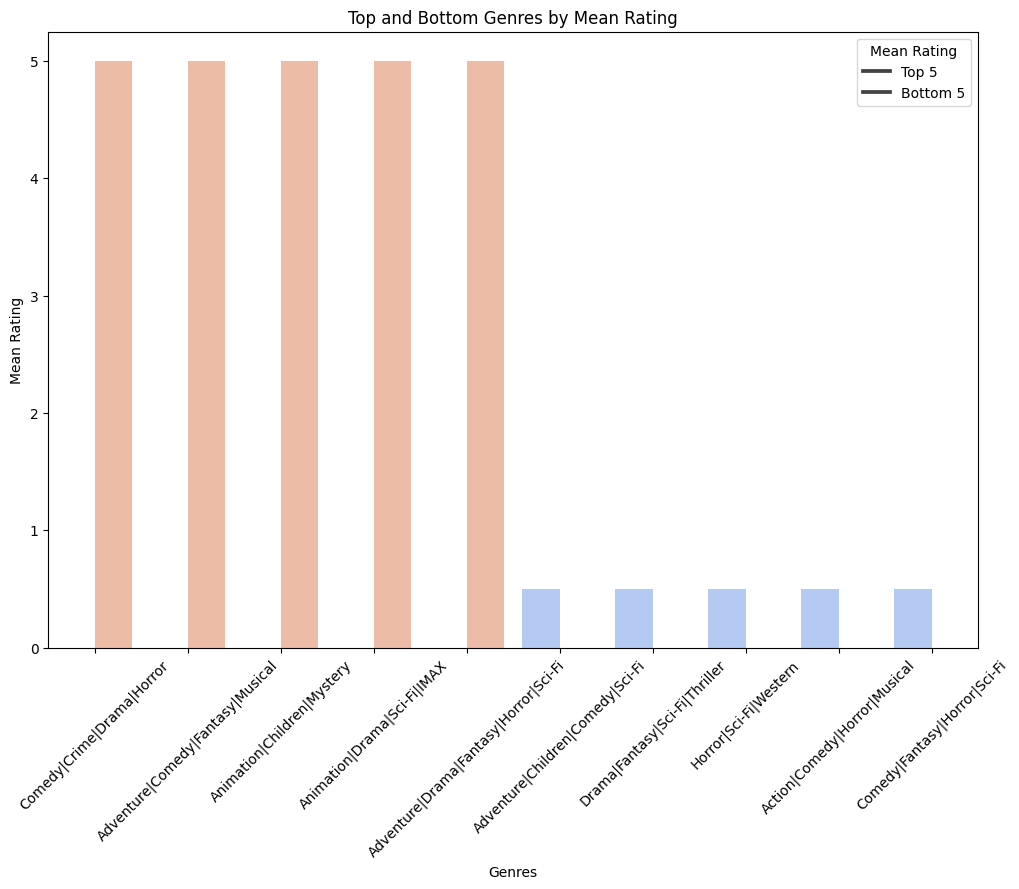

In [20]:
# Calculate the mean rating for each genre
genre_ratings = data.groupby('genres')['rating'].mean().reset_index()

# Sort the genres by mean rating in descending order
sorted_genres = genre_ratings.sort_values(by='rating', ascending=False)

# Get the top five highest-rated genres
top_5_genres = sorted_genres.head(5)

# Get the bottom five least-rated genres
bottom_5_genres = sorted_genres.tail(5)

# Combine the top and bottom genres
combined_genres = pd.concat([top_5_genres, bottom_5_genres])

# Create a bar plot to visualize the combined top and bottom genres by mean rating
plt.figure(figsize=(12, 8))
sns.barplot(x='genres', y='rating', data=combined_genres, hue='rating', palette='coolwarm')
plt.title('Top and Bottom Genres by Mean Rating')
plt.xlabel('Genres')
plt.ylabel('Mean Rating')
plt.legend(title='Mean Rating', loc='upper right', labels=['Top 5', 'Bottom 5'])
plt.xticks(rotation=45)
plt.show()

`Adventure|Children|Comedy|Sci-Fi`, `Drama|Fantasy|Sci-Fi|Thriller`, `Horror|Sci-Fi|Western`, `Action|Comedy|Horror|Musical` and `Comedy|Fantasy|Horror|Sci-Fi` were the least rated genres with ratings of 0.5

`Comedy|Crime|Drama|Horror`, `Adventure|Comedy|Fantasy|Musical`, `Animation|Children|Mystery`, `Animation|Drama|Sci-Fi|IMAX	`,  and `Adventure|Drama|Fantasy|Horror|Sci-Fi` were top five rated genres with ratings of 5


##  Dropping Columns for Modelling
* In line with the objective, `timestamp`, `title`, `year released`, `decade`, were dropped as they will not be used modelling

In [21]:
columns_to_drop = ['timestamp', 'year released', 'decade']
data.drop(columns=columns_to_drop, inplace=True)

## Modelling

## Baseline Model
* The Popularity-Based Recommender which suggests movies  to users based on their overall popularity was used as baseline model

In [22]:
# Calculate the average rating across all users and items
average_rating = data['rating'].mean()

# Create a constant predicted rating for all user-item pairs
predicted_ratings = np.full(len(data), average_rating)

# Calculate RMSE between actual ratings and predicted ratings
rmse = np.sqrt(mean_squared_error(data['rating'], predicted_ratings))

print("RMSE for Popularity-Based Recommender:", rmse)

RMSE for Popularity-Based Recommender: 1.0424637525676965


* The RMSE shows that on average, the predictions made by the `Popularity-Based Recommender` deviate from the actual ratings by approximately 1.0425 units on the rating scale. Given that the ratings are between 0.5 and 5 an RMSE of 1.0425 is large. As such there is need for a better model than the Popularity-Based Recommender with a lower RMSE. 

### Creating surprise datasets

In [23]:
reader = Reader()

# Load the DataFrame into a Surprise dataset
surprise_data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

# Build the full training set
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=42)

#### Advanced modelling 
* This section presents User-Based Collaborative Filtering,  Singular Value Decomposition (SVD), K-Nearest Neighbors (KNN) with means, K-Nearest Neighbors (KNN) basic (KNNBasic) models together with their RMSE

In [24]:
# Initialize  the models
user_based_model = KNNBasic(sim_options={'user_based': True})
user_based_model.fit(trainset)

knn_with_means_model = KNNWithMeans(sim_options={'user_based': True})
knn_with_means_model.fit(trainset)

svd_model = SVD()
svd_model.fit(trainset)

knn_basic_model = KNNBasic(sim_options={'user_based': False})
knn_basic_model.fit(trainset)

# Make predictions on the test set
user_based_predictions = user_based_model.test(testset)
knn_with_means_predictions = knn_with_means_model.test(testset)
svd_predictions = svd_model.test(testset)
knn_basic_predictions = knn_basic_model.test(testset)

# Calculate RMSE 
user_based_rmse = accuracy.rmse(user_based_predictions)
knn_with_means_rmse = accuracy.rmse(knn_with_means_predictions)
svd_rmse = accuracy.rmse(svd_predictions)
knn_basic_rmse = accuracy.rmse(knn_basic_predictions)

# Print the RMSE for each model
print("User-Based Collaborative Filtering RMSE:", user_based_rmse)
print("\nK-Nearest Neighbors with Means RMSE:", knn_with_means_rmse)
print("\nSVD RMSE:", svd_rmse)
print("\nK-Nearest Neighbors Basic RMSE:", knn_basic_rmse)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9465
RMSE: 0.8995
RMSE: 0.8755
RMSE: 0.9139
User-Based Collaborative Filtering RMSE: 0.9465057681809455

K-Nearest Neighbors with Means RMSE: 0.8995372951089837

SVD RMSE: 0.8755406528065686

K-Nearest Neighbors Basic RMSE: 0.9139049164020674


* The above results show that SVD had the least RMSE hence was chosen as the best performing model. 

In [25]:
from surprise import KNNBasic, KNNWithMeans, SVD, accuracy

# Initialize the models with Pearson similarity
user_based_model = KNNBasic(sim_options={'user_based': True, 'sim_options': {'name': 'pearson'}})
user_based_model.fit(trainset)

knn_with_means_model = KNNWithMeans(sim_options={'user_based': True, 'sim_options': {'name': 'pearson'}})
knn_with_means_model.fit(trainset)

# Initialize the SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Initialize the item-based model with Pearson similarity
knn_basic_model = KNNBasic(sim_options={'user_based': False, 'sim_options': {'name': 'pearson'}})
knn_basic_model.fit(trainset)

# Make predictions on the test set
user_based_predictions = user_based_model.test(testset)
knn_with_means_predictions = knn_with_means_model.test(testset)
svd_predictions = svd_model.test(testset)
knn_basic_predictions = knn_basic_model.test(testset)

# Calculate RMSE
user_based_rmse = accuracy.rmse(user_based_predictions)
knn_with_means_rmse = accuracy.rmse(knn_with_means_predictions)
svd_rmse = accuracy.rmse(svd_predictions)
knn_basic_rmse = accuracy.rmse(knn_basic_predictions)

# Print the RMSE for each model
print("User-Based Collaborative Filtering RMSE:", user_based_rmse)
print("\nK-Nearest Neighbors with Means RMSE:", knn_with_means_rmse)
print("\nSVD RMSE:", svd_rmse)
print("\nK-Nearest Neighbors Basic RMSE:", knn_basic_rmse)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9465
RMSE: 0.8995
RMSE: 0.8790
RMSE: 0.9139
User-Based Collaborative Filtering RMSE: 0.9465057681809455

K-Nearest Neighbors with Means RMSE: 0.8995372951089837

SVD RMSE: 0.878997084575833

K-Nearest Neighbors Basic RMSE: 0.9139049164020674


### Model Tuning

In [26]:
# Define the parameter grid for grid search
param_grid = {
    'n_epochs': [5, 10, 15],  # Number of epochs
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate for all parameters
    'reg_all': [0.02, 0.04, 0.06]  # Regularization term for all parameters
}

# Initialize GridSearchCV with the SVD model and parameter grid
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Perform the grid search on the data
grid_search.fit(surprise_data)

# Get the best RMSE score and the corresponding parameters
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best RMSE: 0.8712926559116551
Best Parameters:
n_epochs: 15
lr_all: 0.01
reg_all: 0.06


#### Train SVD model with the best RMSE parameters

In [27]:
# Initialize the SVD model with the best parameters
best_params = {'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.06}
trained_svd_model = SVD(**best_params)

# Fit the SVD model to the training data
trained_svd_model.fit(trainset)

#### Top 5 movie recommendations based on user's ratings
* The function uses past user ratings, deploys the best SVD model to make recommendations. The recommender prompts the user to enter their ` user ID` then based on the  unique ID it  gives recommendations. 
 * In this case I used  `Id 77`

In [28]:
# Prompt the user for their user ID
while True:
    try:
        user_id = int(input("Enter your user ID (an integer between 1 and 610): "))
        if 1 <= user_id <= 610:
            break
        else:
            print("Invalid user ID. Please enter a valid integer between 1 and 610.")
    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Check if the user exists in the ratings dataset
if user_id in data['userId'].unique():
    # User is an existing user
    # print(f"Welcome back, User {user_id}", "Here are movies you may like",)
    print(f"Welcome back User {user_id}, Here are movies you may like:")

    # Use the existing trained SVD model to get movie recommendations for the user
    recommendations = []

   # Get unrated movies for the user
    rated_movie_ids = [item[0] for item in trainset.ur[user_id]]
    unrated_movie_ids = [movie_id for movie_id in trainset.all_items() if movie_id not in rated_movie_ids]

    # Predict ratings for unrated movies using the trained SVD model
    recommendations = []
    for movie_id in unrated_movie_ids:
        predicted_rating = trained_svd_model.predict(user_id, movie_id).est
        recommendations.append((movie_id, predicted_rating))

    # Sort the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get the top 5 unique movie recommendations
    top_recommendations = []
    seen_movie_ids = set()
    for movie_id, predicted_rating in recommendations:
        if movie_id not in seen_movie_ids:
            top_recommendations.append((movie_id, predicted_rating))
            seen_movie_ids.add(movie_id)
            if len(top_recommendations) == 5:
                break


    # Get the top 5 movie recommendations
    top_recommendations = recommendations[:5]

    # Print the top 5 movie recommendations from the data
    print("\nTop 5 movie recommendations based on your ratings:")
    for idx, (movie_id, predicted_rating) in enumerate(top_recommendations):
        movie_title = data[data['movieId'] == movie_id]['title'].values[0]
        print(f"Recommendation #{idx + 1}: {movie_title}")

else:
    # New user without any ratings
    print("Welcome, New User!")

Welcome back User 77, Here are movies you may like:

Top 5 movie recommendations based on your ratings:
Recommendation #1: Matrix, The (1999)
Recommendation #2: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Recommendation #3: Shawshank Redemption, The (1994)
Recommendation #4: Star Wars: Episode IV - A New Hope (1977)
Recommendation #5: Lawrence of Arabia (1962)


## Trained_SVD Model Evaluation

In [29]:
cv_results = cross_validate(trained_svd_model, surprise_data, measures=['RMSE'], cv=5, verbose=True)['test_rmse']
print('test_rmse = ', cv_results.mean()*100,'%')

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8571  0.8677  0.8676  0.8639  0.8580  0.8628  0.0046  
Fit time          1.10    1.27    1.01    0.97    1.02    1.07    0.11    
Test time         0.16    0.16    0.15    0.27    0.17    0.18    0.04    
test_rmse =  86.284097347552 %


* The model has a test RMSE of 86% which shows it performs practically well and makes reasonably accurate predictions for user ratings. Also, a small  standard deviation of 0.0038 shows that  the model's performance is consistent across different data splits.

# Conclusion

The recommendation system has achieved an impressive 86% accuracy in aligning user preferences with movie recommendations. This addresses the challenge of content navigation challenges by delivering tailored movie suggestions ultimately improving watching experience. An accurate recommendation system contributes significantly to user contentment and the platform's success. By streamlining movie searches and maximizing content enjoyment, personalized recommendations improve efficiency and foster loyalty. Users who consistently find appealing content are more likely to stay engaged and loyal, ensuring long-term user retention and platform prosperity

# Recommendations 
* The streaming platform should aim to feature movies rated at least `3.5` and above as they cut across most users. 
* There should be implementation of content-based recommendations which analyze movie attributes such as genre, actors, directors, and user preferences to make more diverse and personalized recommendations. 
* Develop a hybrid recommender system which combine SVD model and content-based recommendation approach to capitalize on the strengths of both methods
